# Homework Excercise

## Input:
 - Sunday.png -> an image of a wood surface just after processing
 - Monday.png -> an image the next day, after damage by a woodchuck

## Output:
  - an image with potential woodchuck damage marks marked
 
## Assume:
  all wood surfaces in the input look the same, and the mark left by the woodchucks is
  similar in size and area, but not identical

# Looking at the images:
 - grayscale images
 - different brightness -> equalize histograms
 - not aligned (looks like rotation)
 - one looks sharper

# Idea:
 - Need to align images (align 1st to second to preserve feature sharpness)
 - Stretch histogram
   - equalization and auto-calculation of alpha and beta smears feature
   - use simple linear stretch
 - Calcaulate diff image
 - Adaptive threshold (neighbourhood-based)
 - Connected Components Labeling - select round components of approx area

# Imports

In [27]:
import cv2
import numpy as np
import os

# For displaying images in the notebook
from IPython.display import Image

# Helper Methods

## Image Alignment

In [28]:
def alignImages(img1, img2,
                max_features = 500, good_match_percent = 15,
                do_show_matches = False):
  # Based on https://learnopencv.com/feature-based-image-alignment-using-opencv-c-python/
  # and https://www.pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/

  #Initialize feature detector -> Use ORB (open and available)
  orb = cv2.ORB_create(max_features)

  # Detect features
  keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
  keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)

  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)

  # Keep best matches
  numGoodMatches = int(len(matches) * good_match_percent/100.0)
  matches = matches[:numGoodMatches]

  # Draw top matches
  if do_show_matches:
    imMatches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)
    cv2.imwrite("matches.png", imMatches)

  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

  # Use homography
  height, width = img2.shape
  im1Reg = cv2.warpPerspective(img1, h, (width, height), borderMode=cv2.BORDER_REPLICATE)

  return im1Reg


## Linear Stretching

In [29]:
def linearStretch(img):
  # Simple linear stretch of pixel intensities
  return ((img-np.amin(img))/(np.amax(img)-np.amin(img))*255)

# Here we go...

In [30]:
def detectFeature(img1, img2, do_show_matches = False):

  # Linear stretch of the test image
  img2_st = linearStretch(img2[15:-15, 15:-15]) # TODO: crude cropping. better crop by bbox of 1

  # Align (warp) source image to test
  img1_w = alignImages(img1, img2, do_show_matches=do_show_matches)

  # ...and stretch it too
  img1_w_st = linearStretch(img1_w[15:-15, 15:-15]) # Note the crop

  # Calculate the diff and stretch for contrast
  img_diff = linearStretch(img1_w_st-img2_st).astype(np.uint8)

  # Calculate adaptive threshold around each pixel:
  #  adaptive threshold block size: large enough to contrast the whole feature we're looking for
  #  offset constant: subtract that from the weighted mean calculated for better contrast
  img_thresh  = cv2.adaptiveThreshold(img_diff,
                                      255,
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY,
                                      25,-15)

  # Connected Components Labeling
  num, img, stats, centroids = cv2.connectedComponentsWithStats(img_thresh,
                                                                connectivity=4)

  # Keep CC of specific area and shape
  # TODO: Crude implementation of "roundness". Could do better...
  points = []
  for l, (x,y) in enumerate(centroids):
    if (20 < stats[l][cv2.CC_STAT_AREA] < 50 and
        0.8 < stats[l][cv2.CC_STAT_WIDTH]/stats[l][cv2.CC_STAT_HEIGHT] < 1.2):
      points.append((round(x)+15, round(y)+15))  # Note the crop compensation offset here

  # Draw overlay of potential features on the original second image
  img_detect = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) # Convert to color so that we can draw in color
  for (x,y) in points:
      cv2.circle(img_detect, (round(x), round(y)), 7, (0,0,255), 2) # Add red circle

  return img_detect

# Test on given input

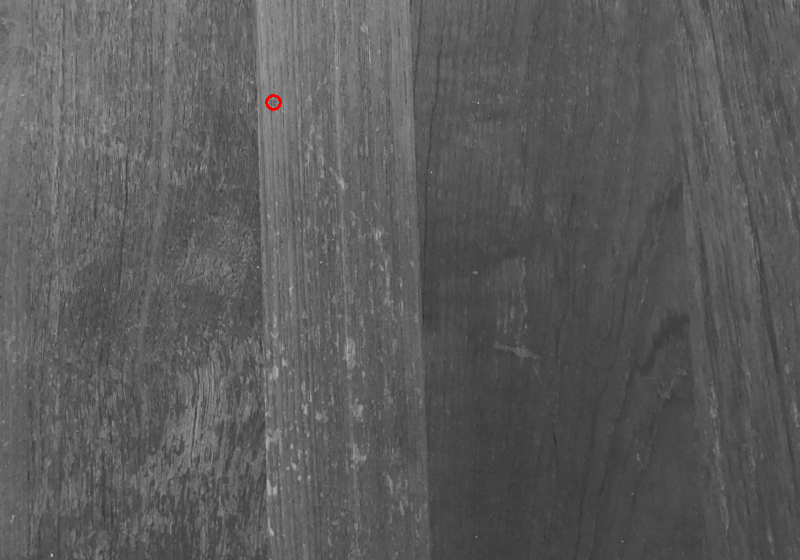

In [31]:
img1 = cv2.imread(os.path.join('Input','Sunday.PNG'), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join('Input', 'Monday.PNG'), cv2.IMREAD_GRAYSCALE)

img_out = detectFeature(img1, img2)
cv2.imwrite('Out.png', img_out)

Image(filename='Out.png')

# Test on another (synthetic) input

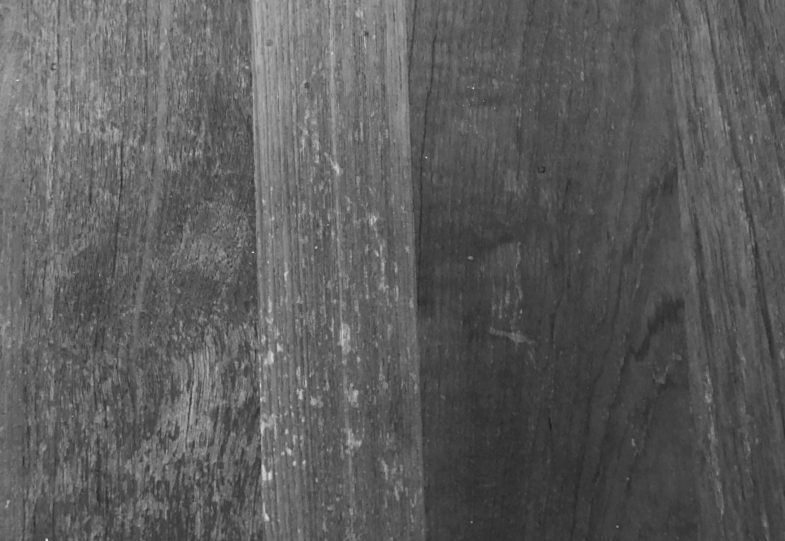

In [32]:
Image(filename=os.path.join('Input', 'Tuesday.PNG'))

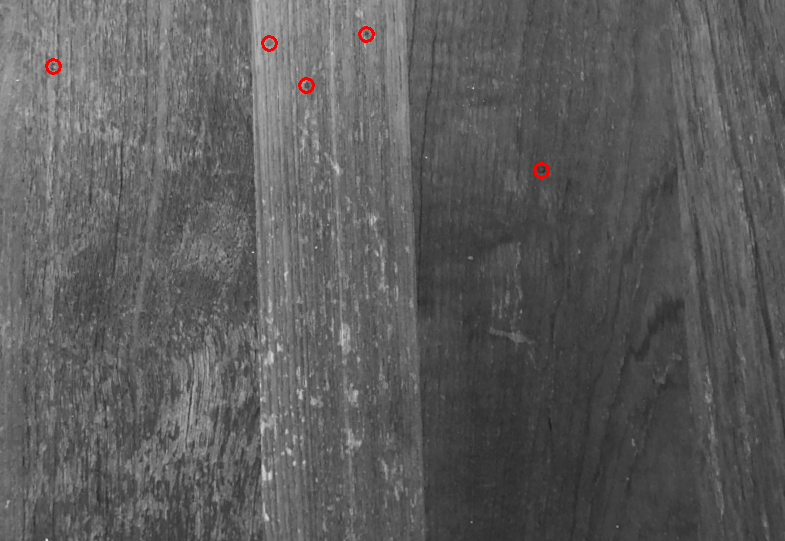

In [34]:
img1 = cv2.imread(os.path.join('Input','Sunday.PNG'), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join('Input', 'Tuesday.PNG'), cv2.IMREAD_GRAYSCALE)

img_out_test = detectFeature(img1, img2)
cv2.imwrite('Out_test.png', img_out_test)

Image(filename='Out_test.png')